# Lab 5 - Clustering and Dimensionality Reduction


- Your name: Nguyen Thi Nha Thu

- Your student code: 19133054

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 172 kB in 1s (118 kB/s)
Reading package lists... Done

## 1. Giới thiệu
### 1.1. Khởi tạo Spark

In [2]:
import findspark
findspark.init()

import pyspark
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import count

spark = (SparkSession
         .builder
         .appName("Clustering")
         .getOrCreate())

### 1.2. Đọc và load tập dữ liệu Iris

In [3]:
irisDF = (spark.read
          .option("HEADER", True)
          .option("inferSchema", True)
          .csv("/content/iris.csv")
         )

irisDF.show(5)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



### 1.3. Tập dữ liệu Iris

`sepal_length`: chiều dài đài hoa (cm)

`sepal_width`: chiều rộng đài hoa (cm)

`petal_length`: chiều dài cánh hoa (cm)

`petal_width`: chiều rộng cánh hoa (cm)

`class/label`: loại hoa

![Iris dataset](./image/iris.png)

### 1.4. Xem các loại biến trong tập dữ liệu

In [4]:
irisDF.dtypes

[('sepal_length', 'double'),
 ('sepal_width', 'double'),
 ('petal_length', 'double'),
 ('petal_width', 'double'),
 ('class', 'string')]

### 1.5. Chuyển cột `class` (kiểu string) thành `label` (kiểu double)

In [5]:
from pyspark.ml.feature import StringIndexer

class_indexer = StringIndexer(inputCol='class',outputCol='label')

irisDFindexed = class_indexer.fit(irisDF).transform(irisDF)

irisDFindexed.show(5)

+------------+-----------+------------+-----------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width|      class|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
+------------+-----------+------------+-----------+-----------+-----+
only showing top 5 rows



### 1.6. Biến đổi data theo định dạng của Spark

In [6]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=['sepal_length','sepal_width','petal_length','petal_width'],
                            outputCol='features')
irisAssembler = vecAssembler.transform(irisDFindexed)

selected_cols = ['sepal_length','sepal_width','petal_length','petal_width', 'features', 'label']

irisFeaturesDF = irisAssembler.select(selected_cols)
irisFeaturesDF.show(5)

+------------+-----------+------------+-----------+-----------------+-----+
|sepal_length|sepal_width|petal_length|petal_width|         features|label|
+------------+-----------+------------+-----------+-----------------+-----+
|         5.1|        3.5|         1.4|        0.2|[5.1,3.5,1.4,0.2]|  0.0|
|         4.9|        3.0|         1.4|        0.2|[4.9,3.0,1.4,0.2]|  0.0|
|         4.7|        3.2|         1.3|        0.2|[4.7,3.2,1.3,0.2]|  0.0|
|         4.6|        3.1|         1.5|        0.2|[4.6,3.1,1.5,0.2]|  0.0|
|         5.0|        3.6|         1.4|        0.2|[5.0,3.6,1.4,0.2]|  0.0|
+------------+-----------+------------+-----------+-----------------+-----+
only showing top 5 rows



## 2. Sử dụng thuật toán gom cụm Kmeans
Tham khảo:

1. [Kmeans User Guides](https://spark.apache.org/docs/latest/ml-clustering.html#k-means)

2. [Kmeans API Docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html#pyspark.ml.clustering.KMeans)

### 2.1 Áp dụng thuật toán `KMeans` trên `irisFeaturesDF` với `k = 3`, `maxIter = 20`

In [7]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k = 3, seed = 1, maxIter = 20)

#  Call fit on the estimator and pass in irisFeaturesDF
model = kmeans.fit(irisFeaturesDF)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedDF = model.transform(irisFeaturesDF)

print(centers)

[array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([5.006, 3.418, 1.464, 0.244]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]


### 2.2. Tính giá trị [silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) của kết quả gom cụm

In [8]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(metricName = "silhouette")

silhouette = evaluator.evaluate(transformedDF)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7354567373091194


### 2.3. Tính F-mearure của kết quả gom cụm dùng true label

Giả sử tập dữ liệu $D$ có $n$ phần tử $x_i$ được phân hoạch thành $p$ nhóm (ở đây ứng với số loài). Gọi $y_i \in \{1, 2, · · · , p\}$ là nhóm thật sự (ground-truth labels) cho mỗi phần tử. Ground-truth clustering được cho bởi $T = \{T_1, T_2, \cdots , T_p\}$, với $T_j$ bao gồm tất cả các phần tử có nhãn $j$, nghĩa là, $T_j = \{ x_i \in D | y_i = j \}$. Mặt khác, gọi $C = \{ C_1, C_2, \cdots, C_k \}$ là một kết quả gom cụm của $D$ thành $k$ cụm (cluster), qua một thuật toán gom cụm nào đó, và $\hat{y_i} \in \{ 1, 2, \cdots, k \}$ là cluster label cho $x_i$. Ta sẽ xem $T$ là một phân hoạch chuẩn (ground-truth partitioning) và mỗi $T_i$ là một phân vùng (partition). Ta gọi $C$ là một kết quả gom cụm (clustering), với mỗi $C_i$ là một cụm (cluster). Giả sử ground truth là biết trước, một thuật toán gom cụm sẽ thực hiện gom cụm trên $D$ với số cụm chính xác, tức với $k = p$. Tuy nhiên, để giữ tính tổng quát, ta cho phép $k \ne p$.

| Clusters/Species | $T_1$ | $T_2$  | $\cdots$ | $T_p$ |
|---|---|---|---|---|
| $C_1$ | $n_{11}$ | $n_{12}$ | $\cdots$ | $n_{1p}$ |
| $C_2$ | $n_{21}$ | $n_{22}$ | $\cdots$ | $n_{2p}$ |
| $\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ |
| $C_k$ | $n_{k1}$ | $n_{k2}$ | $\cdots$ | $n_{kp}$ |

Các độ đo đánh giá kết quả gom cụm cố gắng nắm bắt mức độ mà các phần tử từ cùng một phân vùng (partition) xuất hiện trong cùng một cụm (cluster) và mức độ mà các phần tử từ các phân vùng (partition) khác nhau được nhóm thành các cụm (cluster) khác nhau. Những độ đo này dựa trên $k \times p$ contingency table $N$ (xem bảng trên) được thành lập dựa vào một kết quả gom cụm (clustering) $C$ và một phân hoạch chuẩn (ground-truth partitioning) $T$, được định nghĩa như sau:

$$N(i, j) = n_{ij} = |C_i \cap T_j|$$

- $Recall$ là tỷ lệ đối tượng cùng loài được gán cùng cụm. 

- $Precision$ là tỷ lệ đối tượng được gán cùng cụm thuộc cùng loài. 

- $F{\text -}measure$ là một độ đo cân bằng giữa $Precision$ và $Recall$ và được tính bằng trung bình điều hòa giữa $Precision$ và $Recall$. Đây là một độ đo thường được sử dụng để so sánh các thuật toán gom cụm với nhau.

Các độ đo $Precision$, $Recall$, và $F{\text -}measure$ được tính từ contingency table ở trên dùng các công thức sau:


\begin{equation}
precision = \frac{{\sum\limits_{i = 1}^k {\mathop {{\rm{max}}}\limits_{j \in \left\{ {1, \ldots p} \right\}} \{n_{ij}\} } }}{{\sum\limits_{i = 1}^k {\sum\limits_{j = 1}^p {n_{ij} } } }}
\end{equation}

\begin{equation}
recall = \frac{{\sum\limits_{j = 1}^p {\mathop {{\rm{max}}}\limits_{i \in \left\{ {1, \ldots ,k} \right\}} \{n_{ij}\} } }}{{\sum\limits_{i = 1}^k {\sum\limits_{j = 1}^p {n_{ij} } } }}
\end{equation}

\begin{equation}
\begin{split}
F{\text -}measure = \frac{{2 \cdot precision \cdot recall}}{{precision + recall}}
\end{split}
\end{equation}


In [9]:
# Viết code của bạn ở đây

## 3. Áp dụng PCA

Tham khảo:

1. [PCA User Guides](https://spark.apache.org/docs/latest/ml-features.html#pca)

2. [PCA API Docs](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCA.html#pyspark.ml.feature.PCA)

### 3.1. Thực hiện thu giảm chiều trên `features` dùng PCA, với `k = 2`.

In [10]:
from pyspark.ml.feature import PCA

pca = PCA(k = 2, inputCol = "features", outputCol = "pcaFeatures")
pcaModel = pca.fit(irisFeaturesDF)

irisPCA = pcaModel.transform(irisFeaturesDF).select("features", "pcaFeatures")
irisPCA.show(5, truncate = False)

+-----------------+-----------------------------------------+
|features         |pcaFeatures                              |
+-----------------+-----------------------------------------+
|[5.1,3.5,1.4,0.2]|[-2.8271359726790286,-5.641331045573357] |
|[4.9,3.0,1.4,0.2]|[-2.7959524821488464,-5.1451668832529425]|
|[4.7,3.2,1.3,0.2]|[-2.62152355816506,-5.17737812120394]    |
|[4.6,3.1,1.5,0.2]|[-2.764905900474242,-5.003599415056977]  |
|[5.0,3.6,1.4,0.2]|[-2.7827501159516626,-5.648648294377423] |
+-----------------+-----------------------------------------+
only showing top 5 rows



### 3.2. Áp dụng k-means trên `pcaFeatures` được tạo ra bởi PCA

In [11]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k = 3, seed = 1, maxIter = 20, featuresCol = 'pcaFeatures')

#  Call fit on the estimator and pass in irisPCA
kMeansModel = kmeans.fit(irisPCA)

# Obtain the clusterCenters from the kMeansModel
centers = kMeansModel.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedIrisPCA = kMeansModel.transform(irisPCA)

print(centers)

[array([-6.17577661, -4.98443152]), array([-2.87050234, -5.50524368]), array([-7.85779422, -5.58707828])]


### 3.3. Tính giá trị [silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering)) của kết quả gom cụm

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(metricName = "silhouette")

silhouette = evaluator.evaluate(transformedIrisPCA)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7342113066202725


### 3.4. Tính F-mearure của kết quả gom cụm dùng true label

In [13]:
# Viết code của bạn ở đây


## 4. Áp dụng `Kmeans` với tập dữ liệu `iris`

### 4.1. Tạo `features` column cho tập dữ liệu `iris` chỉ dùng 2 thuộc tính `sepal_length` và `sepal_width`.

In [14]:
# Viết code của bạn ở đây
irisDF2 = irisDF.select("sepal_length", "sepal_width")

irisAssembler = (VectorAssembler( inputCols = ["sepal_length", "sepal_width"],
                    outputCol = "features")
                    .transform(irisDF2))
irisFeaturesDF = irisAssembler.select('features')
irisFeaturesDF.show(5)

+---------+
| features|
+---------+
|[5.1,3.5]|
|[4.9,3.0]|
|[4.7,3.2]|
|[4.6,3.1]|
|[5.0,3.6]|
+---------+
only showing top 5 rows



### 4.2. Áp dụng `Kmeans` cho tập dữ liệu `iris` trên `features` vừa tạo 

Thiết lập các giá trị siêu tham số `k = 3`, `seed = 1`, và `maxIter = 20`. 

Tham khảo document về `Kmeans` của Spark ở [Kmeans](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html#pyspark.ml.clustering.KMeans).

In [15]:
# Viết code của bạn ở đây
kmeans = KMeans(k=3, seed=1, maxIter=20)

#  Call fit on the estimator and pass in irisFeaturesDF
model = kmeans.fit(irisFeaturesDF)

# Obtain the clusterCenters from the KMeansModel
centers = model.clusterCenters()

# Use the model to transform the DataFrame by adding cluster predictions
transformedDF = model.transform(irisFeaturesDF)

print(centers)

transformedDF.show(100,False)

[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
+---------+----------+
|features |prediction|
+---------+----------+
|[5.1,3.5]|1         |
|[4.9,3.0]|1         |
|[4.7,3.2]|1         |
|[4.6,3.1]|1         |
|[5.0,3.6]|1         |
|[5.4,3.9]|1         |
|[4.6,3.4]|1         |
|[5.0,3.4]|1         |
|[4.4,2.9]|1         |
|[4.9,3.1]|1         |
|[5.4,3.7]|1         |
|[4.8,3.4]|1         |
|[4.8,3.0]|1         |
|[4.3,3.0]|1         |
|[5.8,4.0]|1         |
|[5.7,4.4]|1         |
|[5.4,3.9]|1         |
|[5.1,3.5]|1         |
|[5.7,3.8]|1         |
|[5.1,3.8]|1         |
|[5.4,3.4]|1         |
|[5.1,3.7]|1         |
|[4.6,3.6]|1         |
|[5.1,3.3]|1         |
|[4.8,3.4]|1         |
|[5.0,3.0]|1         |
|[5.0,3.4]|1         |
|[5.2,3.5]|1         |
|[5.2,3.4]|1         |
|[4.7,3.2]|1         |
|[4.8,3.1]|1         |
|[5.4,3.4]|1         |
|[5.2,4.1]|1         |
|[5.5,4.2]|1         |
|[4.9,3.1]|1         |
|[5.0,3.2]|1         |
|[5.5,3.5]|1     

### 4.3. Tính giá trị `silhouette` của kết quả gom cụm

In [16]:
# Viết code của bạn ở đây
evaluator = ClusteringEvaluator(metricName="silhouette")

evaluator.evaluate(transformedDF)

0.6144693759745262

### 4.4. Tính F-mearure của kết quả gom cụm dùng true label

In [17]:
# Viết code của bạn ở đây

### 4.4. Áp dụng thuật toán `KMeans` trên `features` đã tạo với `k = 3`, và `maxIter` thay đổi. In ra các centers và chỉ số `silhouette` cho từng kết quả gom cụm.

In [18]:
# Viết code của bạn ở đây
modelCenters = []
silhouetteModel = []
iterations = [0, 2, 4, 7, 10, 20]
for i in iterations:
    kmeans = KMeans(k=3, seed=1, maxIter=i)
    model = kmeans.fit(irisFeaturesDF)
    modelCenters.append(model.clusterCenters())
    
    sillhouette = evaluator.evaluate(transformedDF)
    silhouetteModel.append(sillhouette)

In [19]:
print("modelCenters:")
for centroids in modelCenters:
  print(centroids)

modelCenters:
[array([5.74150943, 2.62075472]), array([5.57804878, 3.33780488]), array([7.47333333, 2.98      ])]
[array([5.87118644, 2.73389831]), array([5.01153846, 3.39230769]), array([6.91025641, 3.08717949])]
[array([5.84909091, 2.70909091]), array([5.00192308, 3.38076923]), array([6.85348837, 3.1       ])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]
[array([5.8, 2.7]), array([5.00392157, 3.4       ]), array([6.82391304, 3.07826087])]


In [20]:
print("silhouettes:")
for silhouette in silhouetteModel:
  print(silhouette)

silhouettes:
0.6144693759745262
0.6144693759745262
0.6144693759745262
0.6144693759745262
0.6144693759745262
0.6144693759745262


### 4.5. Trực quan hóa kết quả gom cụm dùng thư viện `matplotlib`. 
Tham khảo [python-machine-learning-book-chapter10-notebook](https://github.com/rasbt/machine-learning-book/blob/main/ch10/ch10.ipynb).

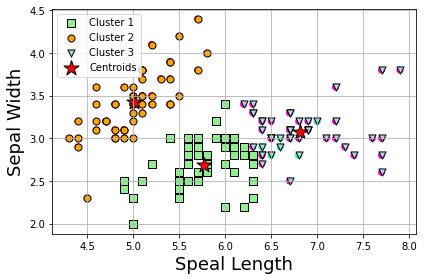

In [21]:
# Viết code của bạn ở đây
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target
plt.scatter(X[:,0], X[:,1], c=y, cmap='gist_rainbow')
plt.xlabel('Speal Length', fontsize=18)
plt.ylabel('Sepal Width', fontsize=18)


km = KMeans(n_clusters = 3, random_state=21)


y_km = km.fit_predict(X)
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

## 5. Áp dụng `BisectingKMeans` trên tập dữ liệu `iris`

Thực lại các bước trên tập dữ liệu iris với thuật toán BisectingKMeans.

Tham khảo: 

1. [BisectingKMeans User Guides](https://spark.apache.org/docs/latest/ml-clustering.html#bisecting-k-means)

2. [BisectingKMeans API Documentations](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.BisectingKMeans.html#pyspark.ml.clustering.BisectingKMeans)

**Bisecting Kmeans** là một thuật toán gọm cụm thuộc nhóm **hierarchical clustering**. Khác với thuật toán **AGNES (agglomerative nesting)** tiếp cận theo hướng **bottom-up**, thuật toán **Bisecting Kmeans** tiếp cận theo hướng **top-down**.

**Ý tưởng của thuật toán Bisecting Kmeans**

Thuật toán khởi đầu bằng việc xem tất cả các điểm dữ liệu thuộc cùng một cụm và sau đó tiến hành như sau:

1. Chọn một cụm để tách
2. Tách cụm đã chọn thành 2 `sub-clusters` dùng thuật toán `K-means`. (`bisecting step`) 
3. Lặp lại bước 2 (`bisecting step`) `iter` lần và chọn ra phép tách tạo ra các cụm có `độ tương tự tổng thể` cao nhất.
4. Lặp lại bước 1, 2, và 3 cho đến khi đạt được số cụm mong muốn. 

- Có nhiều cách khác nhau để **chọn cụm để tách** (bước 1). Ta có thể chọn cụm có kích cỡ lớn nhất (nhiều phần tử nhất) ở mỗi bước, hoặc chọn cụm có độ tương tự tổng thể nhỏ nhất, hoặc chọn cụm dùng cả hai tiêu chí về kích cỡ và độ tương tự tổng thể.

- `Độ tương tự tổng thể` (`overall similarity`) của một cụm được tính bằng độ tương tự trung bình của các cặp phần tử trong cùng một cụm (`pairwise similarity`).

In [22]:
# Viết code của bạn ở đây
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1)
model = bkm.fit(irisAssembler)

In [23]:
# Evaluate clustering.
cost = model.computeCost(irisAssembler)
print("Within Set Sum of Squared Errors = " + str(cost))

Within Set Sum of Squared Errors = 41.36153800650694


/usr/local/lib/python3.7/dist-packages/pyspark/ml/clustering.py:978: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  FutureWarning,


In [24]:
# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[5.5  2.65]
[5.01632653 3.44081633]
[6.58985507 2.96666667]


## 6. Áp dụng `GaussianMixture` trên tập dữ liệu `iris`

Thực lại các bước trên tập dữ liệu iris với thuật toán GaussianMixture.

Tham khảo: 

1. [GaussianMixture User Guides](https://spark.apache.org/docs/latest/ml-clustering.html#gaussian-mixture-model-gmm)

2. [GaussianMixture API Documentations](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.GaussianMixture.html#pyspark.ml.clustering.GaussianMixture)

**Gaussian Mixture Model** là một trường hợp đặt biệt của [**Mixture Model**](https://en.wikipedia.org/wiki/Mixture_model). Mô hình hỗn hợp (mixture model) là một mô hình xác suất biểu diễn cho sự hiện diện của các nhóm con trong một tổng thể. Một mô hình hỗn hợp tương ứng với phân bố hỗn hợp (mixture distribution) biểu diễn phân phối xác suất của các phần tử trong một tổng thể.

Mixture model thuộc lớp các `mô hình sinh` (`generative model`). `Mô hình sinh` dựa trên giả định dữ liệu được sinh từ một mô hình ẩn bên dưới với các tham số. Ta cần tìm cách ước lượng các tham số sao cho nó cực đại hóa xác suất sinh ra dữ liệu. `Mô hình hỗn hợp Gauss` (`Gaussian mixture model`) giả định rằng dữ liệu được sinh từ một tổ hợp các phân bố Gauss. Ta cần ước lượng các tham số của mô hình, tức $\theta = \{(\mu_i, \sigma_i)\}_{i=1..k}$ (mỗi phân bố Gauss được biểu diễn bởi một cặp $(\mu_i, \sigma_i)$), sao cho xác xuất sinh ra tập dữ liệu $D = \{x_1, x_2, \cdots, x_n\}$, $P(D | \theta)$, là lớn nhất. Thuật toán `Expectation-Maximization` (`EM`) thường được sử dụng để ước lượng các tham số cho mô hình `Gaussian mixture model`. Tham khảo thêm [Gaussian mixture model](https://brilliant.org/wiki/gaussian-mixture-model/).

Khác với các thuật toán `gom cụm cứng` (`hard clustering`), Gaussian mixture model được xem là một thuật toán `gom cụm mềm` (`soft clustring`). Mỗi phần tử có thể thuộc nhiều cụm ứng với xác suất khác nhau.

In [25]:
# Viết code của bạn ở đây
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(3).setSeed(538009335)
model = gmm.fit(irisFeaturesDF)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show()

Gaussians shown as a DataFrame: 
+--------------------+--------------------+
|                mean|                 cov|
+--------------------+--------------------+
|[6.05512780452506...|0.327557618491267...|
|[6.33126469977098...|0.517882974473717...|
|[5.01560927774038...|0.119415061646354...|
+--------------------+--------------------+

